# Recreating @eleonoran's implementation which can be found [here](https://ibb.co/h1F0Lh1).

In [1]:
# Set report variables
team_name = 'Chicago'
min_season = '2000-01'
max_season = '2017-18'

In [2]:
import math
import numpy as np 
import pandas as pd
from PIL import Image

import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{xcolor}')
rc('pgf', preamble=r'\usepackage{xcolor}', rcfonts=False)

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None # surpress is copy warning

In [3]:
df = pd.read_csv('../NHL Attendance.csv')
print(df.columns)
print(df.head())

Index(['SEASON', 'RANK', 'TEAM', 'HOME GAMES', ' HOME ATTENDANCE ',
       'ROAD GAMES', ' ROAD ATTENDANCE ', 'TOTAL GAMES', ' TOTAL ATTENDANCE '],
      dtype='object')
    SEASON  RANK          TEAM  HOME GAMES  HOME ATTENDANCE   ROAD GAMES  \
0  2017-18     1       Chicago          41          887,794           41   
1  2017-18     2      Montreal          41          873,283           41   
2  2017-18     3  Philadelphia          41          800,214           41   
3  2017-18     4       Detroit          41          800,115           41   
4  2017-18     5       Toronto          41          786,677           41   

   ROAD ATTENDANCE   TOTAL GAMES  TOTAL ATTENDANCE   
0          723,773            82         1,611,567   
1          733,736            82         1,607,019   
2          702,781            82         1,502,995   
3          717,295            82         1,517,410   
4          751,940            82         1,538,617   


In [4]:
def clean_numeric_column(df, column_name):
    series = df[column_name].str.strip()
    series = series.str.replace(',', '')
    series = pd.to_numeric(series)
    df[column_name] = series
    return df

df = clean_numeric_column(df, ' TOTAL ATTENDANCE ')
df = clean_numeric_column(df, ' HOME ATTENDANCE ')

In [5]:
def get_value_from_column(df, filter_column, filter_value, value_column):
    row = df.query(f'{filter_column} == @filter_value')
    return row.iloc[0][value_column]

In [6]:
# Header - Get totals for seasons
season_sums = df.groupby('SEASON').sum()
season_sums = season_sums.reset_index(level='SEASON')

min_season_attendance = get_value_from_column(season_sums, 'SEASON', min_season, ' HOME ATTENDANCE ')
max_season_attendance = get_value_from_column(season_sums, 'SEASON', max_season, ' HOME ATTENDANCE ')
print('starting attendance: ', min_season_attendance)
print('ending attendance: ', max_season_attendance)

starting attendance:  20399945
ending attendance:  22174263


In [7]:
# Header - Get totals for teams
team_sums = df.query('SEASON == @max_season').groupby('TEAM').sum()
team_sums = team_sums.reset_index(level='TEAM')

top_5_teams = team_sums.sort_values(by=' HOME ATTENDANCE ', ascending=False)[:5]
print(top_5_teams[['TEAM', ' HOME ATTENDANCE ']])

            TEAM   HOME ATTENDANCE 
6        Chicago             887794
15      Montreal             873283
21  Philadelphia             800214
10       Detroit             800115
26       Toronto             786677


In [8]:
# Graphs - Get selected team data
team_df = df.query('TEAM == @team_name')
team_min_season_attendance = get_value_from_column(team_df, 'SEASON', min_season, ' HOME ATTENDANCE ')
print('min season team attendance: ', team_min_season_attendance)

team_df['CHANGE FROM MIN SEASON'] = team_df.apply(lambda row: row[' HOME ATTENDANCE '] - team_min_season_attendance, axis = 1)
print(team_df.head()[['SEASON', ' HOME ATTENDANCE ', 'CHANGE FROM MIN SEASON']])

min season team attendance:  614875
      SEASON   HOME ATTENDANCE   CHANGE FROM MIN SEASON
0    2017-18             887794                  272919
31   2016-17             891827                  276952
61   2015-16             896240                  281365
91   2014-15             892532                  277657
121  2013-14             927545                  312670


In [9]:
# Drawing - Show saved pdf
from wand.image import Image as wandImage  

def show_pdf(file_name):
    imageFromPdf = wandImage(filename=file_name)  
    pages = len(imageFromPdf.sequence)  

    image = wandImage(  
      width=imageFromPdf.width,  
      height=imageFromPdf.height * pages  
    )  
    for i in range(pages):  
      image.composite(  
      imageFromPdf.sequence[i],  
      top=imageFromPdf.height * i,  
      left=0  
    )  
    image.format="png"  
    return image

In [10]:
# Drawing - Bar graph
def format_bar_y(y):
    y = str(y)
    if len(y) > 3:
        return y[:-3] + 'K' 
    
    return y + 'K'


def draw_bar_graph(team_df, min_season, bar_ax):
    bar_ax.set_ylim(-150000, 350000)
    
    hue = team_df['CHANGE FROM MIN SEASON']
    team_df = team_df.sort_values(by='SEASON', ascending=True)
    ax = sns.barplot(
        y='CHANGE FROM MIN SEASON', x='SEASON', data=team_df, ax=bar_ax, zorder=3,
        hue=hue, dodge=False, palette='coolwarm_r'
    )    
    ax.legend_.remove()

    ax.yaxis.grid(color='lightgray', linewidth='0.5', zorder=0)
    ax.set_yticks(np.array([3, 2, 1, 0, -1], dtype=int)*100000)
    ax.tick_params(axis="y", labelsize=22, labelcolor='#666666', width=0)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, p:format_bar_y(y)))
    ax.set_ylabel('Change in home attendance \ncompared to ' + min_season, fontsize=22, labelpad=20)

In [11]:
#Drawing - Line graph
def draw_marker_values(ax, df, y_key, x_key):
    x = df[x_key]
    y = df[y_key]
    
    for i,j in zip(x,y):
        ax.annotate(str(j), xy=(i,j+2), size=20, color='black')

def draw_line_graph(team_df, line_ax):
    hue = team_df['RANK']
    ax = sns.lineplot(
        y='RANK', x='SEASON', data=team_df, 
        drawstyle='steps-pre', color='darkgray', linewidth=3, marker='o',  markersize=8
    )

    ax.tick_params(axis="x", labelsize=18, labelcolor='#666666', bottom=False)
    ax.set_xlabel('')

    ax.yaxis.grid(color='lightgray', linewidth='0.5', zorder=0)
    ax.set_yticks([20, 10])
    ax.tick_params(axis="y", left=False, labelleft=False)
    ax.set_ylabel('Team Rank', fontsize=22, labelpad=100)
    ax.invert_yaxis()

    draw_marker_values(ax, team_df, 'RANK', 'SEASON')

In [12]:
#Drawing - Header
def add_image(image, size_ratio, x, y):
    image = Image.open('./NHL_logo.png')
    image = image.resize( [int(size_ratio * s) for s in image.size] )
    
    image = np.array(image).astype(np.float) / 255
    fig.figimage(image, x, y, zorder=0)
    
def add_dotted_separator(ax, x, y):
    ax.plot(x, y, linestyle = '--', linewidth=4, color='#c5c5c5', dashes=(0.5, 3), dash_capstyle='round')

def add_light_text(ax, text, x, y):
    ax.annotate(text, xy=(1, 1), xytext=(x, y), size=22, color='#666666', horizontalalignment='center')
    
def add_heavy_text(ax, text, x, y, size):
    ax.annotate(text, xy=(1, 1), xytext=(x, y), size=size, color='black', weight='bold', horizontalalignment='center')
    
def add_max_attendence(max_season_attendance, max_season, header_ax, x, y):
    formatted_attendance = round(max_season_attendance / 1000000, 1)
    middleText = str(formatted_attendance) + 'M'    
    bottomText = "people attended NHL games in the\n " + max_season + " season."
    
    add_heavy_text(header_ax, middleText, x, y, 40)
    add_light_text(header_ax, bottomText, x, y-0.14) 
    
def add_attendence_growth(max_season_attendance, min_season_attendance, min_season, header_ax, x, y):
    formatted_attendance = (max_season_attendance / min_season_attendance * 100) - 100
    formatted_attendance = round(formatted_attendance, 1)
    middleText = str(formatted_attendance) + '\%'
    
    add_light_text(header_ax, "The attendance grew by", x, y+0.12) 
    add_heavy_text(header_ax, middleText, x, y, 40)
    add_light_text(header_ax, "since the " + min_season + " season.", x, y-0.08) 

def draw_team_header(top5, rank, ax, x, y):
    team = top5.query('RANK == @rank')
    middleText = team.iloc[0]['TEAM']
    topText = '\#' + str(rank)
    
    formatted_attendance = team.iloc[0][' HOME ATTENDANCE ']
    formatted_attendance = round(formatted_attendance / 1000, 1)
    bottomText = str(formatted_attendance) + 'K home attendees\nin ' + max_season
    
    add_heavy_text(header_ax, topText, x, y+0.1, 30) 
    add_heavy_text(header_ax, middleText, x, y, 30)
    add_light_text(header_ax, bottomText, x, y-0.13) 

def draw_header(team_name, min_season_attendance, max_season_attendance, max_season, top_5_teams, header_ax):
    header_ax.set_xlim(0, 1)
    header_ax.set_ylim(0, 1)
    
    add_image('./NHL_logo.png', 1.2, 100, 1075)
    header_ax.annotate('How has NHL attendance changed over time?', xy=(1, 1), xytext=(0.04, 0.8), size=40, color='black', weight='bold')
    header_ax.annotate('Team stats: ' + team_name, xy=(1, 1), xytext=(-0.085, 0.07), size=40, color='black', weight='bold')

    add_max_attendence(max_season_attendance, max_season, header_ax, 0.125, 0.476)
    add_dotted_separator(header_ax, [0.265, 0.265], [0.25, 0.65])
    add_attendence_growth(max_season_attendance, min_season_attendance, min_season, header_ax, 0.375, 0.424)
    add_dotted_separator(header_ax, [0.485, 0.485], [0.25, 0.65])
    
    draw_team_header(top_5_teams, 1, header_ax, 0.58, 0.466)
    draw_team_header(top_5_teams, 2, header_ax, 0.755, 0.466)
    draw_team_header(top_5_teams, 3, header_ax, 0.93, 0.465)
    header_ax.axis('off')

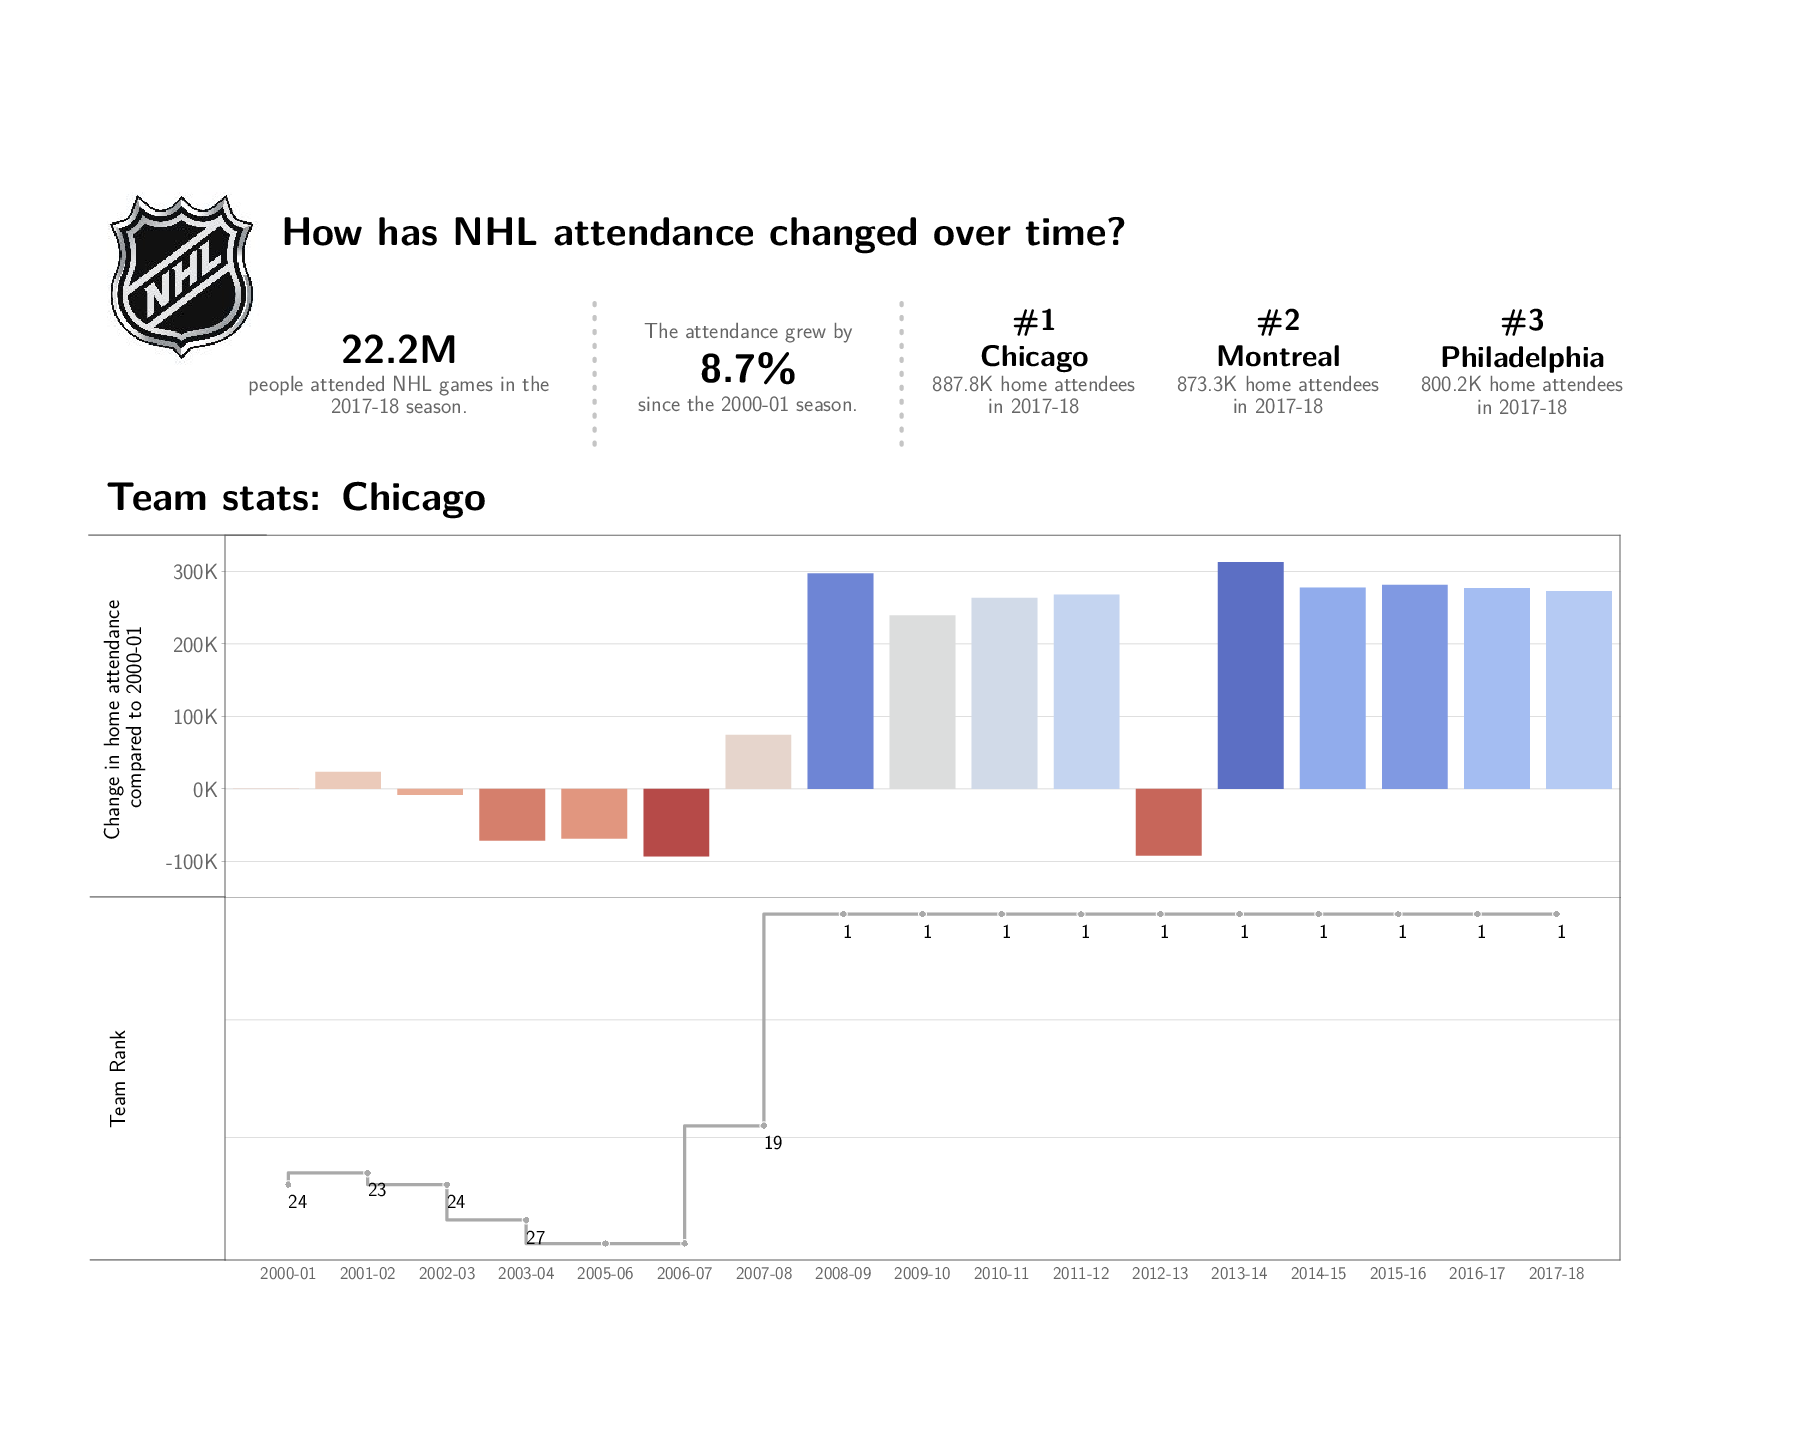

In [19]:
fig, (header_ax, bar_ax, line_ax) = plt.subplots(nrows=3, figsize=(25,20), gridspec_kw={"height_ratios":[0.3, 0.3, 0.3]})
fig.subplots_adjust(wspace=0, hspace=0)
   
draw_bar_graph(team_df, min_season, bar_ax)
draw_line_graph(team_df, line_ax)
draw_header(team_name, min_season_attendance, max_season_attendance, max_season, top_5_teams, header_ax)

plt.setp(bar_ax.spines.values(), color='#666666')
plt.setp(line_ax.spines.values(), color='#666666')
line_ax.spines['top'].set_visible(False)

from matplotlib import lines
def add_line(ax, x, y):
    line = lines.Line2D(x, y, lw=1, color='#666666')
    line.set_clip_on(False)
    ax.add_line(line)

add_line(line_ax, [-2.5, -0.8], [-0.47, -0.47])
add_line(line_ax, [-2.5, -0.8], [30.4, 30.4])
add_line(bar_ax, [-2.16, 0], [350000, 350000])

#Save and show pdf
file_name = 'team_dashboard.pdf'
plt.savefig(file_name)
matplotlib.pyplot.close(fig) #do not draw
show_pdf(file_name)